In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import requests
import json
from pandas import json_normalize
import plotly.graph_objects as go
import seaborn as sns

# ELO Project - All Years

## Functions creating ELO

In [6]:
# Initial Variables that affect ELO
initial_rating = 1500
K = 16 # factor at which scores are updated
home_advantage = 32 # should be in number of elo points

def sigmoid_strength_of_victory(goal_dif, equation=1, elo_diff=0):
    """
    Calculate the strength of victory for a winning team based on the goal difference and optional parameters.

    Parameters:
    goal_dif (numeric): The goal difference for the match for the winning team.
    equation (int, optional): The equation used to calculate the strength of victory. Defaults to 1.
    elo_diff (numeric, optional): The Elo rating difference between the two teams. Defaults to 0.

    Returns:
    float: The strength of victory, representing the reward for the winning team.

    The function calculates the strength of victory based on different equations depending on the chosen equation
    parameter.

    If equation = 1:
        The function uses a sigmoid function to determine the strength of victory. A team that wins by a larger goal
        difference should be rewarded more, but extremely large wins are not overvalued.

    If equation = 2:
        The function uses the 538 Model to calculate the strength of victory. This model takes into account
        both the goal difference and the Elo rating difference between the teams. This has not been fully implemented yet.

    Example:
    goal_dif = 5
    equation = 1
    sigmoid_strength_of_victory(goal_dif, equation)  # Returns 1.2294464977081369

    goal_dif = 4
    equation = 2
    elo_diff = 100
    sigmoid_strength_of_victory(goal_dif, equation, elo_diff)  # Returns 0.8648752922373572
    """

    if equation == 1: 
        sov = (6.2 / (2 + math.exp(-(1 / 5) * (goal_dif - 8))))
    elif equation == 2:
        sov = np.log(goal_dif + 3) * (5.5 / ((elo_diff / 1000) + 5.5))
    return sov

def calculate_expected(team1, team2):
    """
    Calculate the expected outcome of a match between two teams, taking into account the home team advantage.

    Parameters:
    team1 (numeric): Elo rating for the first team.
    team2 (numeric): Elo rating for the second team.

    Returns:
    float: The expected probability of the first team winning, considering the home team advantage.

    The function uses the Elo rating system formula to calculate the expected outcome of a match. The Elo rating
    represents the skill level of a team or player. The higher the Elo rating, the stronger the team.

    The home team advantage is factored into the calculation by adjusting the Elo rating of the home team. The home
    team advantage is represented by a numeric value.

    Example:
    team1 = 1600
    team2 = 1500
    home_advantage = 100
    calculate_expected(team1, team2)  # Returns 0.7597468482494313

    team1 = 1500
    team2 = 1600
    home_advantage = 100
    calculate_expected(team1, team2) # Returns 0.5
    """
    team1_expected = 1 / (1 + math.pow(10, (team2 - (team1 + home_advantage)) / 400))
    return team1_expected


def update_ratings(home_team_rating, away_team_rating, goal_difference):
    """
    Update team ratings based on match outcome and goal difference.

    Parameters:
    home_team_rating (numeric): The rating of the home team.
    away_team_rating (numeric): The rating of the away team.
    goal_difference (numeric): The difference in goals between the home and away team.

    Returns:
    float: The updated rating of the home team.

    The function updates the ratings of the home team based on the match outcome and goal difference. The outcome is
    determined by the goal difference, where a goal difference of 0 results in a draw (outcome = 0.5), a positive goal
    difference indicates a win for the home team (outcome = 1), and a negative goal difference indicates a loss for the
    home team (outcome = 0).

    The expected outcome is calculated using the 'calculate_expected' function, which estimates the probability of the
    home team winning based on their rating and the away team's rating.

    The strength of victory is calculated using the 'sigmoid_strength_of_victory' function, which determines the
    reward for the home team based on the goal difference.

    The updated rating is computed using the formula:
    updated_rating = home_team_rating + (K * strength_of_victory * (outcome - expected))

    Example:
    home_team_rating = 1500
    away_team_rating = 1600
    goal_difference = 2
    update_ratings(home_team_rating, away_team_rating, goal_difference)  # Returns the updated rating of the home team
    """

    outcome = 0.5 if goal_difference == 0 else 1 if goal_difference > 0 else 0

    expected = calculate_expected(home_team_rating, away_team_rating)

    strength_of_victory = sigmoid_strength_of_victory(goal_difference)

    updated_rating = home_team_rating + (K * strength_of_victory * (outcome - expected))
    return updated_rating

def update_away_ratings(home_team_rating, away_team_rating, goal_difference):
    """
    Update the away team's rating based on the match outcome and goal difference.

    Parameters:
    home_team_rating (numeric): The rating of the home team.
    away_team_rating (numeric): The rating of the away team.
    goal_difference (numeric): The difference in goals between the home and away team.

    Returns:
    float: The updated rating of the away team.

    The function updates the rating of the away team based on the match outcome and goal difference. The outcome is
    determined by the goal difference, where a goal difference of 0 results in a draw (outcome = 0.5), an absolute
    goal difference greater than 0 indicates a loss for the away team (outcome = 0), and an absolute goal difference
    equal to 0 indicates a win for the away team (outcome = 1).

    The expected outcome is calculated using the Elo rating formula, which estimates the probability of the away team
    winning based on the ratings of the home and away teams. The formula used is:
    expected = 1 / (1 + math.pow(10, ((home_team_rating + home_advantage) - away_team_rating) / 400))

    The strength of victory is calculated using the 'sigmoid_strength_of_victory' function, which determines the
    reward for the away team based on the absolute value of the goal difference.

    The updated rating is computed using the formula:
    updated_rating = away_team_rating + (K * strength_of_victory * (outcome - expected))

    Example:
    home_team_rating = 1600
    away_team_rating = 1500
    goal_difference = -1
    update_away_ratings(home_team_rating, away_team_rating, goal_difference)  # Returns the updated rating of the away team
    """

    outcome = 0.5 if goal_difference == 0 else 1 if abs(goal_difference) > 0 else 0

    expected = 1 / (1 + math.pow(10, ((home_team_rating + home_advantage) - away_team_rating) / 400))

    strength_of_victory = sigmoid_strength_of_victory(abs(goal_difference))

    updated_rating = away_team_rating + (K * strength_of_victory * (outcome - expected))
    return updated_rating

In [7]:
# Open and load the JSON file
with open('data/game_results.json') as f:
    data = json.load(f)

# Convert the JSON data to a DataFrame
df = pd.json_normalize(data)
df

id                       date   time   timestamp timezone week  \
0     109064  2012-08-24T17:45:00+00:00  17:45  1345830300      UTC    1   
1     109065  2012-08-25T14:00:00+00:00  14:00  1345903200      UTC    1   
2     109066  2012-08-25T17:00:00+00:00  17:00  1345914000      UTC    1   
3     109067  2012-08-25T17:00:00+00:00  17:00  1345914000      UTC    1   
4     109068  2012-08-25T17:00:00+00:00  17:00  1345914000      UTC    1   
...      ...                        ...    ...         ...      ...  ...   
2777   77392  2023-06-11T13:30:00+00:00  13:30  1686490200      UTC   34   
2778   77393  2023-06-11T13:30:00+00:00  13:30  1686490200      UTC   34   
2779   77394  2023-06-11T13:30:00+00:00  13:30  1686490200      UTC   34   
2780   77395  2023-06-11T13:30:00+00:00  13:30  1686490200      UTC   34   
2781   77396  2023-06-11T13:30:00+00:00  13:30  1686490200      UTC   34   

     status.long status.short  country.id country.name  ...  \
0       Finished           FT          13      Germany  ...   
1       Finished           FT          13      Germany  ...   
2       Finished           FT          13      Germany  ...   
3       Finished           FT          13      Germany  ...   
4       Finished           FT          13      Germany  ...   
...          ...          ...         ...          ...  ...   
2777    Finished           FT          13      Germany  ...   
2778    Finished           FT          13      Germany  ...   
2779    Finished           FT          13      Germany  ...   
2780    Finished           FT          13      Germany  ...   
2781    Finished           FT          13      Germany  ...   

                                        teams.home.logo teams.away.id  \
0     https://media-3.api-sports.io/handball/teams/3...           324   
1     https://media-3.api-sports.io/handball/teams/3...           321   
2     https://media-3.api-sports.io/handball/teams/3...           326   
3     https://media-1.api-sports.io/handball/teams/3...           319   
4     https://media-1.api-sports.io/handball/teams/3...           317   
...                                                 ...           ...   
2777  https://media-1.api-sports.io/handball/teams/3...           322   
2778  https://media-1.api-sports.io/handball/teams/3...           328   
2779  https://media-1.api-sports.io/handball/teams/3...           315   
2780  https://media-1.api-sports.io/handball/teams/3...           339   
2781  https://media-2.api-sports.io/handball/teams/3...           320   

               teams.away.name  \
0                 MT Melsungen   
1                         Kiel   
2                   N-Lubbecke   
3                      Hamburg   
4     HBW Balingen-Weilstetten   
...                        ...   
2777                   Leipzig   
2778              SC Magdeburg   
2779             Fuchse Berlin   
2780               Gummersbach   
2781         Hannover-Burgdorf   

                                        teams.away.logo scores.home  \
0     https://media-2.api-sports.io/handball/teams/3...        23.0   
1     https://media-1.api-sports.io/handball/teams/3...        25.0   
2     https://media-2.api-sports.io/handball/teams/3...        29.0   
3     https://media-1.api-sports.io/handball/teams/3...        33.0   
4     https://media-1.api-sports.io/handball/teams/3...        25.0   
...                                                 ...         ...   
2777  https://media-3.api-sports.io/handball/teams/3...        28.0   
2778  https://media-1.api-sports.io/handball/teams/3...        30.0   
2779  https://media-3.api-sports.io/handball/teams/3...        35.0   
2780  https://media-2.api-sports.io/handball/teams/3...        38.0   
2781  https://media-1.api-sports.io/handball/teams/3...        31.0   

     scores.away  periods.first.home  periods.first.away periods.second.home  \
0           23.0                12.0                10.0                11.0   
1           34.0                10.0     

In [8]:
def clean_df(df):
    df = df[["date", "week", "teams.home.name", "scores.home", "teams.away.name", "scores.away", "league.season"]]
    df['difference'] = df['scores.home'] - df['scores.away']
    df = df[df['week'] != "Final"]
    df['week'] = df['week'].astype(int)
    return df

In [9]:
df = clean_df(df)
df

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_11630/1218006157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['difference'] = df['scores.home'] - df['scores.away']


date  week    teams.home.name  scores.home  \
0     2012-08-24T17:45:00+00:00     1     Grosswallstadt         23.0   
1     2012-08-25T14:00:00+00:00     1        Gummersbach         25.0   
2     2012-08-25T17:00:00+00:00     1              Lemgo         29.0   
3     2012-08-25T17:00:00+00:00     1        HSG Wetzlar         33.0   
4     2012-08-25T17:00:00+00:00     1  Hannover-Burgdorf         25.0   
...                         ...   ...                ...          ...   
2777  2023-06-11T13:30:00+00:00    34     Hamm-Westfalen         28.0   
2778  2023-06-11T13:30:00+00:00    34        HSG Wetzlar         30.0   
2779  2023-06-11T13:30:00+00:00    34              Lemgo         35.0   
2780  2023-06-11T13:30:00+00:00    34             Minden         38.0   
2781  2023-06-11T13:30:00+00:00    34          Stuttgart         31.0   

               teams.away.name  scores.away  league.season  difference  
0                 MT Melsungen         23.0           2012         0.0  
1                         Kiel         34.0           2012        -9.0  
2                   N-Lubbecke         32.0           2012        -3.0  
3                      Hamburg         26.0           2012         7.0  
4     HBW Balingen-Weilstetten         20.0           2012         5.0  
...                        ...          ...            ...         ...  
2777                   Leipzig         33.0           2022        -5.0  
2778              SC Magdeburg         35.0           2022        -5.0  
2779             Fuchse Berlin         32.0           2022         3.0  
2780               Gummersbach         38.0           2022         0.0  
2781         Hannover-Burgdorf         34.0           2022        -3.0  

[2776 rows x 8 columns]

## Baseline ELO Model

In [10]:
# Create a dictionary to store the latest ELO rating for each team
elo_dict = {}
end_of_season_elo_dict = {}

# Initialize a variable to keep track of the current season
current_season = df['league.season'].iloc[0]

# The regression factor and the initial Elo rating for new teams
regression_factor = 0.67
initial_elo = 1500

# Get the set of all teams
teams = set(df['teams.home.name']).union(set(df['teams.away.name']))

# Create empty lists to store the new ELO ratings and the ratings before the match
home_elo_ratings = []
away_elo_ratings = []
home_elo_before_match = []
away_elo_before_match = []

# Go through each row in the dataframe
for idx, row in df.iterrows():

    home_team = row['teams.home.name']
    away_team = row['teams.away.name']
    score_diff = row['difference']
    
    # Check if the home team is in the Elo ratings dictionary
    if home_team not in elo_dict:
        elo_dict[home_team] = 1500

    # Check if the away team is in the Elo ratings dictionary
    if away_team not in elo_dict:
        elo_dict[away_team] = 1500

    # Check if the season has changed
    if row['league.season'] != current_season:
        end_of_season_elo_dict[current_season] = sum(elo_dict.values())
        # If the season has changed, regress the Elo ratings towards the mean
        for team in elo_dict:
            elo_dict[team] = regression_factor * (elo_dict[team] - initial_elo) + initial_elo

        # Update the current season
        current_season = row['league.season']

    # Store the ratings before the match
    home_elo_before_match.append(elo_dict[home_team])
    away_elo_before_match.append(elo_dict[away_team])
    
    if score_diff >= 0: 
        new_home_elo = update_ratings(elo_dict[home_team], elo_dict[away_team], score_diff)
        new_away_elo = elo_dict[away_team] - (new_home_elo - elo_dict[home_team])
    
    else: 
        new_away_elo = update_away_ratings(elo_dict[home_team], elo_dict[away_team], score_diff)
        new_home_elo = elo_dict[home_team] - (new_away_elo - elo_dict[away_team])

    home_elo_ratings.append(new_home_elo)
    away_elo_ratings.append(new_away_elo)

        # Update the ELO ratings in our dictionary
    elo_dict[home_team] = new_home_elo
    elo_dict[away_team] = new_away_elo

# Add the new ELO ratings to the dataframe
df['home_elo_rating'] = home_elo_ratings
df['away_elo_rating'] = away_elo_ratings

# Add the ELO ratings before the match to the dataframe
df['home_elo_before_match'] = home_elo_before_match
df['away_elo_before_match'] = away_elo_before_match

df

date  week    teams.home.name  scores.home  \
0     2012-08-24T17:45:00+00:00     1     Grosswallstadt         23.0   
1     2012-08-25T14:00:00+00:00     1        Gummersbach         25.0   
2     2012-08-25T17:00:00+00:00     1              Lemgo         29.0   
3     2012-08-25T17:00:00+00:00     1        HSG Wetzlar         33.0   
4     2012-08-25T17:00:00+00:00     1  Hannover-Burgdorf         25.0   
...                         ...   ...                ...          ...   
2777  2023-06-11T13:30:00+00:00    34     Hamm-Westfalen         28.0   
2778  2023-06-11T13:30:00+00:00    34        HSG Wetzlar         30.0   
2779  2023-06-11T13:30:00+00:00    34              Lemgo         35.0   
2780  2023-06-11T13:30:00+00:00    34             Minden         38.0   
2781  2023-06-11T13:30:00+00:00    34          Stuttgart         31.0   

               teams.away.name  scores.away  league.season  difference  \
0                 MT Melsungen         23.0           2012         0.0   
1                         Kiel         34.0           2012        -9.0   
2                   N-Lubbecke         32.0           2012        -3.0   
3                      Hamburg         26.0           2012         7.0   
4     HBW Balingen-Weilstetten         20.0           2012         5.0   
...                        ...          ...            ...         ...   
2777                   Leipzig         33.0           2022        -5.0   
2778              SC Magdeburg         35.0           2022        -5.0   
2779             Fuchse Berlin         32.0           2022         3.0   
2780               Gummersbach         38.0           2022         0.0   
2781         Hannover-Burgdorf         34.0           2022        -3.0   

      home_elo_rating  away_elo_rating  home_elo_before_match  \
0         1499.344825      1500.655175            1500.000000   
1         1480.787291      1519.212709            1500.000000   
2         1488.522209      1511.477791            1500.000000   
3         1513.982898      1486.017102            1500.000000   
4         1511.785229      1488.214771            1500.000000   
...               ...              ...                    ...   
2777      1289.908552      1498.906273            1297.227330   
2778      1382.593553      1788.559570            1385.373228   
2779      1564.311325      1679.713735            1550.552490   
2780      1317.695457      1490.321137            1314.857372   
2781      1412.169846      1539.747398            1420.324508   

      away_elo_before_match  
0               1500.000000  
1               1500.000000  
2               1500.000000  
3               1500.000000  
4               1500.000000  
...                     ...  
2777            1491.587495  
2778            1785.779895  
2779            1693.472570  
2780            1493.159223  
2781            1531.592736  

[2776 rows x 12 columns]

## Initialization of probabilites for betting

In [11]:
# Calculate the expected outcome (win probability) for the home team and the away team
df['home_win_probability'] = 1 / (1 + 10**(((df['away_elo_before_match'] - (df['home_elo_before_match'] + home_advantage)) / 400))) * 100
df['away_win_probability'] = 100 - df['home_win_probability']

## Making graphs

In [12]:
# Rewrite the format of the date
df['date'] = pd.to_datetime(df['date']).dt.date

# Split the dataframe into home and away matches
df_home = df[['date', 'league.season', 'teams.home.name', 'home_elo_rating']]
df_away = df[['date', 'league.season', 'teams.away.name', 'away_elo_rating']]

# Rename the columns to prepare for the pivot
df_home.columns = ['Date','Season','Team', 'Rating']
df_away.columns = ['Date','Season','Team', 'Rating']

# Append the dataframes
df_all = df_home.append(df_away)

# Pivot the dataframe
df_pivot = df_all.pivot_table(index = "Team", columns = 'Date', values = 'Rating')

# Sort the columns
df_pivot = df_pivot.sort_index(axis=1)

df_pivot = df_pivot.fillna(method = 'ffill', axis = 1)

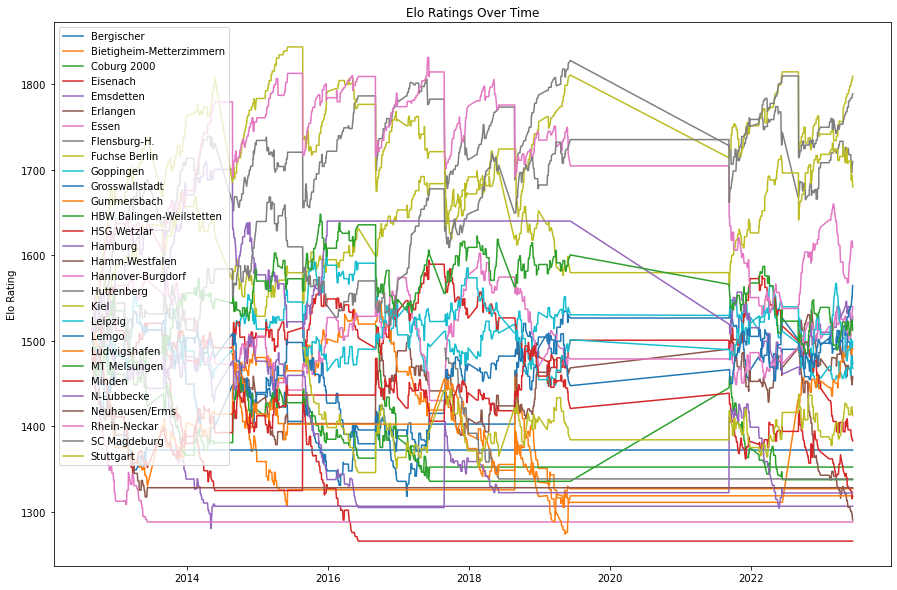

In [13]:
# Plot each team's Elo rating over time
plt.figure(figsize=(15,10))

for team in df_pivot.index:
    plt.plot(df_pivot.columns, df_pivot.loc[team], label=team)

plt.ylabel('Elo Rating')
plt.title('Elo Ratings Over Time')
plt.legend(loc='upper left')
plt.show()

## Plotly Graph

In [14]:
fig = go.Figure()

for team in df_pivot.index:
    # Split the data for each team into two parts with a gap
    team_data_before_gap = df_pivot.loc[team, :pd.to_datetime('2018-07-31')]
    team_data_after_gap = df_pivot.loc[team, pd.to_datetime('2021-07-01'):]

    # Plot the parts separately
    fig.add_trace(go.Scatter(x=team_data_before_gap.index, 
                             y=team_data_before_gap,
                             mode='lines',
                             name=team))
    fig.add_trace(go.Scatter(x=team_data_after_gap.index, 
                             y=team_data_after_gap,
                             mode='lines',
                             name=team,
                             line=dict(color=fig['data'][-1]['line']['color']),  # same color as before
                             showlegend=False))  # don't add to legend again

fig.update_layout(title='Elo Ratings Over Time',
                  xaxis_title='Date',
                  yaxis_title='Elo Rating')

fig.show()

/Users/aditsaxena/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py:3361: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

/Users/aditsaxena/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:1601: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [15]:
for team in df_pivot.index:
    fig.add_trace(go.Scatter(x=df_pivot.columns, 
                             y=df_pivot.loc[team],
                             mode='lines',
                             name=team))

fig.update_layout(title='Elo Ratings Over Time',
                  xaxis_title='Date',
                  yaxis_title='Elo Rating')

fig.show()

## Re-indexing to look at results on a Season by Season Basis

In [16]:
# Split the dataframe into home and away matches
df_home = df[['date', 'league.season', 'teams.home.name', 'home_elo_before_match']]
df_away = df[['date', 'league.season', 'teams.away.name', 'away_elo_before_match']]

# Rename the columns to prepare for the pivot
df_home.columns = ['Date','Season','Team', 'Rating']
df_away.columns = ['Date','Season','Team', 'Rating']

# Append the dataframes
df_all = df_home.append(df_away)

# Pivot the dataframe

df_pivot = df_all.pivot_table(index = "Team", columns = ['Season', 'Date'], values = 'Rating')

# Sort the columns
df_pivot = df_pivot.sort_index(axis=1)

df_pivot = df_pivot.fillna(method = 'ffill', axis = 1)

In [17]:
# Change to look at a specific season
season = 2016

fig = go.Figure()

# Filter DataFrame for anyseason
df_pivot_filtered = df_pivot.xs(season, level='Season', axis=1)

for team in df_pivot_filtered.index:
    fig.add_trace(go.Scatter(x=df_pivot_filtered.columns, 
                             y=df_pivot_filtered.loc[team],
                             mode='lines',
                             name=team))

fig.update_layout(title=f'Elo Ratings Over Time for {season} Season',
                  xaxis_title='Date',
                  yaxis_title='Elo Rating')

fig.show()

In [18]:
# # Generate a plot for each team over time
# teams = df_pivot.index.unique()

# for team in teams:
#     plt.figure(figsize=(10,6))
#     df_team = df_pivot.loc[team].transpose().reset_index()
    
#     # Ensure 'Date' is datetime object
#     df_team['Date'] = pd.to_datetime(df_team['Date'])
    
#     sns.lineplot(x='Date', y=team, data=df_team)
#     plt.title(f'ELO Rating Over Time for {team}')
#     plt.xlabel('Season, Date')
#     plt.ylabel('ELO Rating')
#     plt.show()

In [19]:
df_pivot

Season                         2012                                     \
Date                     2012-08-24 2012-08-25 2012-08-26   2012-08-28   
Team                                                                     
Bergischer                      NaN        NaN        NaN          NaN   
Bietigheim-Metterzimmern        NaN        NaN        NaN          NaN   
Coburg 2000                     NaN        NaN        NaN          NaN   
Eisenach                        NaN        NaN        NaN          NaN   
Emsdetten                       NaN        NaN        NaN          NaN   
Erlangen                        NaN        NaN        NaN          NaN   
Essen                           NaN     1500.0     1500.0  1500.000000   
Flensburg-H.                    NaN     1500.0     1500.0  1500.000000   
Fuchse Berlin                   NaN        NaN     1500.0  1510.660066   
Goppingen                       NaN        NaN     1500.0  1500.000000   
Grosswallstadt               1500.0     1500.0     1500.0  1500.000000   
Gummersbach                     NaN     1500.0     1500.0  1500.000000   
HBW Balingen-Weilstetten        NaN     1500.0     1500.0  1500.000000   
HSG Wetzlar                     NaN     1500.0     1500.0  1500.000000   
Hamburg                         NaN     1500.0     1500.0  1500.000000   
Hamm-Westfalen                  NaN        NaN        NaN          NaN   
Hannover-Burgdorf               NaN     1500.0     1500.0  1500.000000   
Huttenberg                      NaN        NaN        NaN          NaN   
Kiel                            NaN     1500.0     1500.0  1500.000000   
Leipzig                         NaN        NaN        NaN          NaN   
Lemgo                           NaN     1500.0     1500.0  1500.000000   
Ludwigshafen                    NaN        NaN        NaN          NaN   
MT Melsungen                 1500.0     1500.0     1500.0  1500.000000   
Minden                          NaN        NaN     1500.0  1500.000000   
N-Lubbecke                      NaN     1500.0     1500.0  1500.000000   
Neuhausen/Erms                  NaN        NaN     1500.0  1482.327236   
Rhein-Neckar                    NaN        NaN     1500.0  1500.000000   
SC Magdeburg                    NaN        NaN     1500.0  1500.000000   
Stuttgart                       NaN        NaN        NaN          NaN   

Season                                                                        \
Date                       2012-08-31   2012-09-01   2012-09-02   2012-09-04   
Team                                                                           
Bergischer                        NaN          NaN          NaN          NaN   
Bietigheim-Metterzimmern          NaN          NaN          NaN          NaN   
Coburg 2000                       NaN          NaN          NaN          NaN   
Eisenach                          NaN          NaN          NaN          NaN   
Emsdetten                         NaN          NaN          NaN          NaN   
Erlangen                          NaN          NaN          NaN          NaN   
Essen                     1500.000000  1500.000000  1478.454987  1478.454987   
Flensburg-H.              1500.000000  1500.000000  1500.000000  1500.000000   
Fuchse Berlin             1510.660066  1510.660066  1510.660066  1510.660066   
Goppingen                 1500.000000  1500.000000  1485.831038  1485.831038   
Grosswallstadt            1500.000000  1499.344825  1499.344825  1499.344825   
Gummersbach               1480.787291  1480.787291  1480.787291  1480.787291   
HBW Balingen-Weilstetten  1500.000000  1488.214771  1488.214771  1488.214771   
HSG Wetzlar               1500.000000  1513.982898  1513.982898  1513.982898   
Hamburg                   1500.000000  1486.017102  1486.017102  1503.594360   
Hamm-Westfalen                    NaN          NaN          NaN          NaN   
Hannover-Burgdorf         1500.000000  1511.785229  1511.785229  1511.785229   
Huttenberg                     

In [20]:
df_pivot.iloc[:, -1]

Team
Bergischer                  1482.594781
Bietigheim-Metterzimmern    1327.683562
Coburg 2000                 1340.123238
Eisenach                    1268.033288
Emsdetten                   1308.683877
Erlangen                    1448.212463
Essen                       1290.827669
Flensburg-H.                1702.583949
Fuchse Berlin               1693.472570
Goppingen                   1472.104252
Grosswallstadt              1374.678714
Gummersbach                 1493.159223
HBW Balingen-Weilstetten    1346.580624
HSG Wetzlar                 1385.373228
Hamburg                     1516.051139
Hamm-Westfalen              1297.227330
Hannover-Burgdorf           1531.592736
Huttenberg                  1340.686216
Kiel                        1804.521912
Leipzig                     1491.587495
Lemgo                       1550.552490
Ludwigshafen                1308.092068
MT Melsungen                1524.274381
Minden                      1314.857372
N-Lubbecke                  1327.58

## Sanity check to see if ELO's match

In [21]:
season = 2016  # replace with the season you're interested in

elo_before_season = end_of_season_elo_dict[season - 1] if season - 1 in end_of_season_elo_dict else "Data not available"
elo_after_season = end_of_season_elo_dict[season] if season in end_of_season_elo_dict else "Data not available"

print(f"Sum of Elo ratings before the start of season {season}: {elo_before_season}")
print(f"Sum of Elo ratings after the end of season {season}: {elo_after_season}")

Sum of Elo ratings before the start of season 2016: 39000.0
Sum of Elo ratings after the end of season 2016: 40500.00000000001


## Checking Model Accuracy

In [22]:
# Create a column to indicate whether the home team won, lost or tied
df['home_team_won'] = np.where(df['scores.home'] > df['scores.away'], 'Won',
                               np.where(df['scores.home'] < df['scores.away'], 'Lost', 'Tied'))

# Create a column to check if the home_win_probability was correct
# If home_win_probability > 50, the model predicts home team to win
# If home_win_probability < 50, the model predicts home team to lose
# If it's a tie, the prediction is considered correct only if home_win_probability is exactly 50%
conditions = (
    ((df['home_win_probability'] > 50) & (df['home_team_won'] == 'Won')) |
    ((df['home_win_probability'] < 50) & (df['home_team_won'] == 'Lost')) |
    ((df['home_win_probability'] == 50) & (df['home_team_won'] == 'Tied'))
)
df['prediction_correct'] = np.where(conditions, 'Yes', 'No')

In [23]:
# Create a column to indicate the bin for each game's home win probability
df['probability_bin'] = pd.cut(df['home_win_probability'], bins=np.arange(0, 110, 5))

# Group by the probability bin and calculate the percentage of correct predictions in each bin
accuracy_by_bin = df.groupby('probability_bin')['prediction_correct'].apply(lambda x: (x == 'Yes').mean() * 100)

# Group by the probability bin, calculate the percentage of correct predictions 
# in each bin and also count the number of predictions
grouped = df.groupby('probability_bin').agg({'prediction_correct': lambda x: (x == 'Yes').mean() * 100,
                                             'home_win_probability': 'count'})

# Rename the columns for clarity
grouped.columns = ['Accuracy (%)', 'Sample Size']

print(grouped)

                 Accuracy (%)  Sample Size
probability_bin                           
(0, 5]                    NaN            0
(5, 10]             88.888889           18
(10, 15]            92.187500           64
(15, 20]            83.838384           99
(20, 25]            73.584906          106
(25, 30]            72.297297          148
(30, 35]            62.721893          169
(35, 40]            51.136364          176
(40, 45]            51.298701          154
(45, 50]            39.622642          212
(50, 55]            52.313167          281
(55, 60]            57.613169          243
(60, 65]            67.811159          233
(65, 70]            72.772277          202
(70, 75]            84.375000          160
(75, 80]            89.102564          156
(80, 85]            92.045455          176
(85, 90]            93.859649          114
(90, 95]            96.825397           63
(95, 100]          100.000000            2
(100, 105]                NaN            0


In [24]:
# Group by the league.season and probability bin, calculate the percentage of correct predictions 
# in each bin and also count the number of predictions
grouped_season = df.groupby(['league.season', 'probability_bin']).agg({'prediction_correct': lambda x: (x == 'Yes').mean() * 100,
                                                                       'home_win_probability': 'count'})

# Rename the columns for clarity
grouped_season.columns = ['Accuracy (%)', 'Sample Size']

pd.options.display.max_rows = 100
grouped_season

Accuracy (%)  Sample Size
league.season probability_bin                           
2012          (0, 5]                    NaN            0
              (5, 10]                   NaN            0
              (10, 15]           100.000000            1
              (15, 20]           100.000000            5
              (20, 25]           100.000000            3
...                                     ...          ...
2022          (80, 85]            93.548387           31
              (85, 90]            88.888889            9
              (90, 95]           100.000000            5
              (95, 100]                 NaN            0
              (100, 105]                NaN            0

[189 rows x 2 columns]

In [25]:
yes_count = 0
no_count = 0

for entry in df.prediction_correct:
    if entry.lower() == "yes":
        yes_count += 1
    elif entry.lower() == "no":
        no_count += 1
ties_count = df["home_team_won"].value_counts().get("Tied", 0)

print(f"The number of ties is: {ties_count}")
print("Total 'yes' count:", yes_count)
print("Total 'no' count:", no_count)
print(yes_count/ (yes_count + no_count) * 100)

The number of ties is: 254
Total 'yes' count: 1900
Total 'no' count: 876
68.44380403458213


## Start of Betting Analysis
### Naive Betting Analysis

In [26]:
df_odds = pd.read_excel("odds (manual)/odds1.xlsx")
df_odds

Unnamed: 0                       date  week    teams.home.name  \
0              0  2012-08-24T17:45:00+00:00     1     Grosswallstadt   
1              1  2012-08-25T14:00:00+00:00     1        Gummersbach   
2              2  2012-08-25T17:00:00+00:00     1              Lemgo   
3              3  2012-08-25T17:00:00+00:00     1        HSG Wetzlar   
4              4  2012-08-25T17:00:00+00:00     1  Hannover-Burgdorf   
...          ...                        ...   ...                ...   
2771        2777  2023-06-11T13:30:00+00:00    34     Hamm-Westfalen   
2772        2778  2023-06-11T13:30:00+00:00    34        HSG Wetzlar   
2773        2779  2023-06-11T13:30:00+00:00    34              Lemgo   
2774        2780  2023-06-11T13:30:00+00:00    34             Minden   
2775        2781  2023-06-11T13:30:00+00:00    34          Stuttgart   

      scores.home           teams.away.name  scores.away  league.season  \
0              23              MT Melsungen           23           2012   
1              25                      Kiel           34           2012   
2              29                N-Lubbecke           32           2012   
3              33                   Hamburg           26           2012   
4              25  HBW Balingen-Weilstetten           20           2012   
...           ...                       ...          ...            ...   
2771           28                   Leipzig           33           2022   
2772           30              SC Magdeburg           35           2022   
2773           35             Fuchse Berlin           32           2022   
2774           38               Gummersbach           38           2022   
2775           31         Hannover-Burgdorf           34           2022   

      difference  home_elo_rating  ...  home_elo_before_match  \
0              0      1499.127141  ...            1500.000000   
1             -9      1477.554969  ...            1500.000000   
2             -3      1483.335282  ...            1500.000000   
3              7      1517.695800  ...            1500.000000   
4              5      1515.856842  ...            1500.000000   
...          ...              ...  ...                    ...   
2771          -5      1267.779427  ...            1276.099482   
2772          -5      1364.282569  ...            1367.062526   
2773           3      1588.725884  ...            1568.110018   
2774           0      1311.148833  ...            1303.902429   
2775          -3      1423.635784  ...            1435.806566   

      away_elo_before_match  home_win_probability  away_win_probability  \
0               1500.000000             52.875056             47.124944   
1               1500.000000             52.875056             47.124944   
2               1500.000000             52.875056             47.124944   
3               1500.000000             52.875056             47.124944   
4               1500.000000             52.875056             47.124944   
...                     ...                   ...                   ...   
2771            1489.492498             24.726368             75.273632   
2772            1805.253830              8.261752             91.738248   
2773            1698.799385             34.588446             65.411554   
2774            1504.420213             26.131521             73.868479   
2775            1536.319083             38.616361             61.383639   

      home_team_won prediction_correct probability_bin  odds-1   odds-X  \
0              Tied                 No        (50, 60]  -106.0    794.0   
1              Lost                 No        (50, 60]  1084.0  15666.0   
2              Lost                 No        (50, 60]  -250.0    947.0   
3               Won                Yes        (50, 60]   373.0   1069.0   
4               Won                Yes        (50, 60]  -286.0    969.0   
...             ...                ...             ...     ...      ...   
2771           Lost              

In [27]:
def convert_us_odds_to_percent(odds):
    if odds >= 0:
        percent = 100 / (odds + 100) * 100
    else:
        percent = (odds / (odds - 100)) * 100
    return percent

# Apply the conversion function to create a new column with percentages
df_odds['book_percentage_1'] = df_odds['odds-1'].apply(convert_us_odds_to_percent)
df_odds['book_percentage_X'] = df_odds['odds-X'].apply(convert_us_odds_to_percent)
df_odds['book_percentage_2'] = df_odds['odds-2'].apply(convert_us_odds_to_percent)

df_odds

Unnamed: 0                       date  week    teams.home.name  \
0              0  2012-08-24T17:45:00+00:00     1     Grosswallstadt   
1              1  2012-08-25T14:00:00+00:00     1        Gummersbach   
2              2  2012-08-25T17:00:00+00:00     1              Lemgo   
3              3  2012-08-25T17:00:00+00:00     1        HSG Wetzlar   
4              4  2012-08-25T17:00:00+00:00     1  Hannover-Burgdorf   
...          ...                        ...   ...                ...   
2771        2777  2023-06-11T13:30:00+00:00    34     Hamm-Westfalen   
2772        2778  2023-06-11T13:30:00+00:00    34        HSG Wetzlar   
2773        2779  2023-06-11T13:30:00+00:00    34              Lemgo   
2774        2780  2023-06-11T13:30:00+00:00    34             Minden   
2775        2781  2023-06-11T13:30:00+00:00    34          Stuttgart   

      scores.home           teams.away.name  scores.away  league.season  \
0              23              MT Melsungen           23           2012   
1              25                      Kiel           34           2012   
2              29                N-Lubbecke           32           2012   
3              33                   Hamburg           26           2012   
4              25  HBW Balingen-Weilstetten           20           2012   
...           ...                       ...          ...            ...   
2771           28                   Leipzig           33           2022   
2772           30              SC Magdeburg           35           2022   
2773           35             Fuchse Berlin           32           2022   
2774           38               Gummersbach           38           2022   
2775           31         Hannover-Burgdorf           34           2022   

      difference  home_elo_rating  ...  away_win_probability  home_team_won  \
0              0      1499.127141  ...             47.124944           Tied   
1             -9      1477.554969  ...             47.124944           Lost   
2             -3      1483.335282  ...             47.124944           Lost   
3              7      1517.695800  ...             47.124944            Won   
4              5      1515.856842  ...             47.124944            Won   
...          ...              ...  ...                   ...            ...   
2771          -5      1267.779427  ...             75.273632           Lost   
2772          -5      1364.282569  ...             91.738248           Lost   
2773           3      1588.725884  ...             65.411554            Won   
2774           0      1311.148833  ...             73.868479           Tied   
2775          -3      1423.635784  ...             61.383639           Lost   

      prediction_correct  probability_bin  odds-1   odds-X  odds-2  \
0                     No         (50, 60]  -106.0    794.0   112.0   
1                     No         (50, 60]  1084.0  15666.0 -2000.0   
2                     No         (50, 60]  -250.0    947.0   254.0   
3                    Yes         (50, 60]   373.0   1069.0  -385.0   
4                    Yes         (50, 60]  -286.0    969.0   286.0   
...                  ...              ...     ...      ...     ...   
2771                 Yes         (20, 30]     NaN      NaN     NaN   
2772                 Yes          (0, 10]     NaN      NaN     NaN   
2773                  No         (30, 40]     NaN      NaN     NaN   
2774                  No         (20, 30]     NaN      NaN     NaN   
2775                 Yes         (30, 40]     NaN      NaN     NaN   

     book_percentage_1  book_percentage_X  book_percentage_2  
0            51.456311          11.185682          47.169811  
1             8.445946           0.634276          95.238095  
2            71.428571           9.551098          28.248588  
3            21.141649           8.554320          79.381443  
4            74.093264           9.354537          25.906736  
...                ...                ...                ...  
2771     

In [28]:
df_odds.loc[(0.4 < df_odds['home_win_probability']) & (df_odds['home_win_probability'] <= 0.5), ['to_bet_1', 'to_bet_X', 'to_bet_2']] = 0

thresh = 5
def to_bet(row):
    if abs(row['book_percentage_1'] - row['home_win_probability']) > thresh:
        return 1
    if row['home_win_probability'] < 40 or row['home_win_probability'] > 60:
        return 0
    else:
        return 0

df_odds['to_bet_1'] = df_odds.apply(to_bet, axis=1)

df_odds

Unnamed: 0                       date  week    teams.home.name  \
0              0  2012-08-24T17:45:00+00:00     1     Grosswallstadt   
1              1  2012-08-25T14:00:00+00:00     1        Gummersbach   
2              2  2012-08-25T17:00:00+00:00     1              Lemgo   
3              3  2012-08-25T17:00:00+00:00     1        HSG Wetzlar   
4              4  2012-08-25T17:00:00+00:00     1  Hannover-Burgdorf   
...          ...                        ...   ...                ...   
2771        2777  2023-06-11T13:30:00+00:00    34     Hamm-Westfalen   
2772        2778  2023-06-11T13:30:00+00:00    34        HSG Wetzlar   
2773        2779  2023-06-11T13:30:00+00:00    34              Lemgo   
2774        2780  2023-06-11T13:30:00+00:00    34             Minden   
2775        2781  2023-06-11T13:30:00+00:00    34          Stuttgart   

      scores.home           teams.away.name  scores.away  league.season  \
0              23              MT Melsungen           23           2012   
1              25                      Kiel           34           2012   
2              29                N-Lubbecke           32           2012   
3              33                   Hamburg           26           2012   
4              25  HBW Balingen-Weilstetten           20           2012   
...           ...                       ...          ...            ...   
2771           28                   Leipzig           33           2022   
2772           30              SC Magdeburg           35           2022   
2773           35             Fuchse Berlin           32           2022   
2774           38               Gummersbach           38           2022   
2775           31         Hannover-Burgdorf           34           2022   

      difference  home_elo_rating  ...  probability_bin  odds-1   odds-X  \
0              0      1499.127141  ...         (50, 60]  -106.0    794.0   
1             -9      1477.554969  ...         (50, 60]  1084.0  15666.0   
2             -3      1483.335282  ...         (50, 60]  -250.0    947.0   
3              7      1517.695800  ...         (50, 60]   373.0   1069.0   
4              5      1515.856842  ...         (50, 60]  -286.0    969.0   
...          ...              ...  ...              ...     ...      ...   
2771          -5      1267.779427  ...         (20, 30]     NaN      NaN   
2772          -5      1364.282569  ...          (0, 10]     NaN      NaN   
2773           3      1588.725884  ...         (30, 40]     NaN      NaN   
2774           0      1311.148833  ...         (20, 30]     NaN      NaN   
2775          -3      1423.635784  ...         (30, 40]     NaN      NaN   

      odds-2  book_percentage_1 book_percentage_X book_percentage_2 to_bet_1  \
0      112.0          51.456311         11.185682         47.169811        0   
1    -2000.0           8.445946          0.634276         95.238095        1   
2      254.0          71.428571          9.551098         28.248588        1   
3     -385.0          21.141649          8.554320         79.381443        1   
4      286.0          74.093264          9.354537         25.906736        1   
...      ...                ...               ...               ...      ...   
2771     NaN                NaN               NaN               NaN        0   
2772     NaN                NaN               NaN               NaN        0   
2773     NaN                NaN               NaN               NaN        0   
2774     NaN                NaN               NaN               NaN        0   
2775     NaN                NaN               NaN               NaN        0   

      to_bet_X  to_bet_2  
0          NaN       NaN  
1          NaN       NaN  
2          NaN       NaN  
3          NaN       NaN  
4          NaN       NaN  
...        ...       ...  
2771       NaN       NaN  
2772       NaN       NaN  
2773       NaN       NaN  
2774       NaN       NaN  
2775       NaN       NaN  

[2776 rows x 27 columns]

In [29]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50

def calculate_winnings(row):
    bet = 100  # Amount of money you bet on each game
    
    if row['to_bet_1'] == 1 and row['prediction_correct'] == "Yes" and row['home_team_won'] == 'Won':
        if row['odds-1'] > 0:  # Positive odds
            return bet + (bet * row['odds-1'] / 100)
        else:  # Negative odds
            return bet + (bet * 100 / abs(row['odds-1']))
    elif row['to_bet_1'] == 1 and row['prediction_correct'] == "No":
        return -bet
    else: 
        return 0
    
df_odds['winnings'] = df_odds.apply(calculate_winnings, axis=1)

df_odds[2470:2500]

Unnamed: 0                       date  week    teams.home.name  \
2470        2476  2022-09-01T17:05:00+00:00     1           Erlangen   
2471        2477  2022-09-01T17:05:00+00:00     1              Lemgo   
2472        2478  2022-09-01T17:05:00+00:00     1            Hamburg   
2473        2479  2022-09-01T17:05:00+00:00     1  Hannover-Burgdorf   
2474        2480  2022-09-03T18:30:00+00:00     1       Rhein-Neckar   
2475        2481  2022-09-04T12:00:00+00:00     1       SC Magdeburg   
2476        2482  2022-09-04T14:05:00+00:00     1      Fuchse Berlin   
2477        2483  2022-09-04T14:05:00+00:00     1               Kiel   
2478        2484  2022-09-04T14:05:00+00:00     1             Minden   
2479        2485  2022-09-07T17:05:00+00:00     2         Bergischer   
2480        2486  2022-09-07T17:05:00+00:00     2       Flensburg-H.   
2481        2487  2022-09-07T17:05:00+00:00     2          Goppingen   
2482        2488  2022-09-07T17:05:00+00:00     2        HSG Wetzlar   
2483        2489  2022-09-07T17:05:00+00:00     2            Leipzig   
2484        2490  2022-09-08T17:05:00+00:00     2        Gummersbach   
2485        2491  2022-09-08T17:05:00+00:00     2     Hamm-Westfalen   
2486        2492  2022-09-08T17:05:00+00:00     2       MT Melsungen   
2487        2493  2022-09-08T17:05:00+00:00     2          Stuttgart   
2488        2494  2022-09-10T16:30:00+00:00     3  Hannover-Burgdorf   
2489        2495  2022-09-10T18:30:00+00:00     3      Fuchse Berlin   
2490        2496  2022-09-10T18:30:00+00:00     3              Lemgo   
2491        2497  2022-09-11T12:00:00+00:00     3               Kiel   
2492        2498  2022-09-11T14:05:00+00:00     3           Erlangen   
2493        2499  2022-09-11T14:05:00+00:00     3        Gummersbach   
2494        2500  2022-09-11T14:05:00+00:00     3            Hamburg   
2495        2501  2022-09-11T16:15:00+00:00     3       SC Magdeburg   
2496        2502  2022-09-15T17:05:00+00:00     4         Bergischer   
2497        2503  2022-09-15T17:05:00+00:00     4       Flensburg-H.   
2498        2504  2022-09-15T17:05:00+00:00     3       Rhein-Neckar   
2499        2505  2022-09-17T16:30:00+00:00     4     Hamm-Westfalen   

      scores.home    teams.away.name  scores.away  league.season  difference  \
2470           31        HSG Wetzlar           27           2022           4   
2471           26        Gummersbach           30           2022          -4   
2472           30       Flensburg-H.           31           2022          -1   
2473           25            Leipzig           22           2022           3   
2474           36       MT Melsungen           25           2022          11   
2475           31     Hamm-Westfalen           23           2022           8   
2476           34          Goppingen           27           2022           7   
2477           36          Stuttgart           23           2022          13   
2478           25         Bergischer           28           2022          -3   
2479           22  Hannover-Burgdorf           23           2022          -1   
2480           36             Minden           23           2022          13   
2481           34              Lemgo           31           2022           3   
2482           25      Fuchse Berlin           37           2022         -12   
2483           22               Kiel           32           2022         -10   
2484           28       SC Magdeburg           30           2022          -2   
2485           30       Rhein-Neckar           35           2022          -5   
2486           30            Hamburg           27           2022           3   
2487           27           Erlangen           29           2022          -2   
2488           25       Flensburg-H.           35           2022         -10   
2489           31          Stuttgart           21           2022          10   
2490           28       MT Melsungen           28           2022           0   
2491         

In [30]:
df_odds['winnings'].sum()

2392.577824525376

In [31]:
df_odds.head(30)

Unnamed: 0                       date  week           teams.home.name  \
0            0  2012-08-24T17:45:00+00:00     1            Grosswallstadt   
1            1  2012-08-25T14:00:00+00:00     1               Gummersbach   
2            2  2012-08-25T17:00:00+00:00     1                     Lemgo   
3            3  2012-08-25T17:00:00+00:00     1               HSG Wetzlar   
4            4  2012-08-25T17:00:00+00:00     1         Hannover-Burgdorf   
5            5  2012-08-25T17:00:00+00:00     1              Flensburg-H.   
6            6  2012-08-26T13:30:00+00:00     1                 Goppingen   
7            7  2012-08-26T15:30:00+00:00     1              SC Magdeburg   
8            8  2012-08-26T15:30:00+00:00     1             Fuchse Berlin   
9            9  2012-08-28T18:15:00+00:00     2            Neuhausen/Erms   
10          10  2012-08-31T17:45:00+00:00     2                    Minden   
11          11  2012-09-01T17:00:00+00:00     2                N-Lubbecke   
12          12  2012-09-01T17:00:00+00:00     2              MT Melsungen   
13          13  2012-09-01T17:00:00+00:00     2  HBW Balingen-Weilstetten   
14          14  2012-09-01T17:00:00+00:00     2                   Hamburg   
15          15  2012-09-02T13:00:00+00:00     2                 Goppingen   
16          16  2012-09-02T15:30:00+00:00     2                     Essen   
17          17  2012-09-04T18:15:00+00:00     3              SC Magdeburg   
18          18  2012-09-05T17:00:00+00:00     3                    Minden   
19          19  2012-09-05T17:00:00+00:00     3               HSG Wetzlar   
20          20  2012-09-05T18:15:00+00:00     3                     Lemgo   
21          21  2012-09-05T18:15:00+00:00     3         Hannover-Burgdorf   
22          22  2012-09-05T18:15:00+00:00     3               Gummersbach   
23          23  2012-09-05T18:15:00+00:00     3             Fuchse Berlin   
24          24  2012-09-05T18:15:00+00:00     3              Flensburg-H.   
25          25  2012-09-05T18:15:00+00:00     3              Rhein-Neckar   
26          26  2012-09-07T17:45:00+00:00     4            Grosswallstadt   
27          27  2012-09-08T18:15:00+00:00     4                 Goppingen   
28          28  2012-09-08T18:15:00+00:00     4            Neuhausen/Erms   
29          29  2012-09-08T18:15:00+00:00     4              MT Melsungen   

    scores.home           teams.away.name  scores.away  league.season  \
0            23              MT Melsungen           23           2012   
1            25                      Kiel           34           2012   
2            29                N-Lubbecke           32           2012   
3            33                   Hamburg           26           2012   
4            25  HBW Balingen-Weilstetten           20           2012   
5            40                     Essen           20           2012   
6            25              Rhein-Neckar           30           2012   
7            35            Neuhausen/Erms           24           2012   
8            29                    Minden           25           2012   
9            22             Fuchse Berlin           29           2012   
10           27               Gummersbach           31           2012   
11           36         Hannover-Burgdorf           28           2012   
12           23              Rhein-Neckar           26           2012   
13           26               HSG Wetzlar           28           2012   
14           29            Grosswallstadt           19           2012   
15           33                     Lemgo           28           2012   
16           26              SC Magdeburg           32           2012   
17           28                   Hamburg           29           2012   
18           28            Neuhausen/Erms           23           2012   
19           26            Grosswallstadt           25           2012   
20           31              MT Melsungen           28           2012   
21        

In [32]:
def calculate_results(df):
    # Number of winning bets
    winning_bets = len(df[(df['to_bet_1'] == 1) & (df['prediction_correct'] == "Yes") & (df['home_team_won'] == "Won")])

    # Number of losing bets
    losing_bets = len(df[(df['to_bet_1'] == 1) & (df['prediction_correct'] == "No")])

    # Total number of bets
    total_bets = winning_bets + losing_bets

    # Win rate
    if total_bets > 0:
        win_rate = winning_bets / total_bets * 100
    else:
        win_rate = 0

    profit = df['winnings'].sum()
    print(f"Number of winning bets: {winning_bets}")
    print(f"Number of losing bets: {losing_bets}")
    print(f"Total bets: {total_bets}")
    print(f"Winning percentage: {round(win_rate,2)}%")
    print(f"Profit: {round(profit,2)}")

calculate_results(df_odds)

Number of winning bets: 25
Number of losing bets: 10
Total bets: 35
Winning percentage: 71.43%
Profit: 2392.58


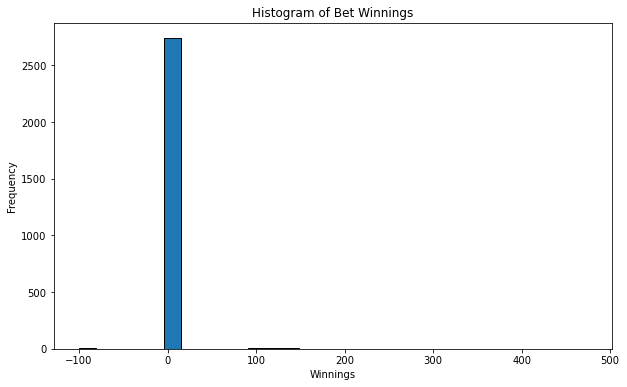

In [33]:
plt.figure(figsize=(10,6))
plt.hist(df_odds['winnings'], bins=30, edgecolor='black')
plt.title('Histogram of Bet Winnings')
plt.xlabel('Winnings')
plt.ylabel('Frequency')
plt.show()


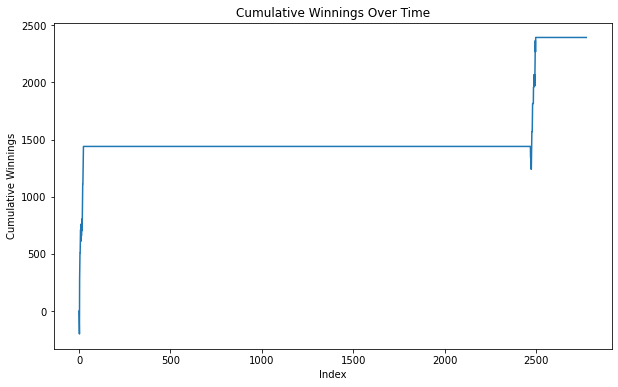

In [34]:
plt.figure(figsize=(10,6))
df_odds['winnings'].cumsum().plot()
plt.title('Cumulative Winnings Over Time')
plt.xlabel('Index')
plt.ylabel('Cumulative Winnings')
plt.show()


## Goal Differences

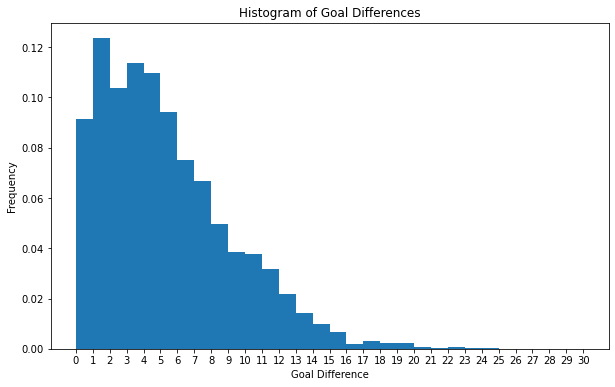

In [35]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and "goal_difference" is your column
plt.figure(figsize=(10, 6))  # set figure size, this is optional
plt.hist(abs(df["difference"]), bins=30, range=(0, 30), density = True) 
plt.title('Histogram of Goal Differences')  # add title to the plot
plt.xlabel('Goal Difference')  # add x-axis label
plt.ylabel('Frequency')  # add y-axis label
plt.xticks(range(0, 31))  # set x-axis ticks to show every integer between 1 and 30
plt.show()



In [36]:
x = np.quantile(abs(df['difference']), [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
print(x)

[ 0.  1.  1.  2.  3.  4.  5.  6.  8. 10. 24.]


In [37]:
abs(df['difference']).median()

4.0

## More Betting Analysis with Real Data
### Real Betting Analysis

I got data from betsapi, and am just going to be merging it in with this dataframe. 

In [38]:
import pandas as pd

home_names = df['teams.home.name'].unique()
away_names = df['teams.away.name'].unique()

unique_names = set(home_names).union(away_names)

unique_names

{'Bergischer',
 'Bietigheim-Metterzimmern',
 'Coburg 2000',
 'Eisenach',
 'Emsdetten',
 'Erlangen',
 'Essen',
 'Flensburg-H.',
 'Fuchse Berlin',
 'Goppingen',
 'Grosswallstadt',
 'Gummersbach',
 'HBW Balingen-Weilstetten',
 'HSG Wetzlar',
 'Hamburg',
 'Hamm-Westfalen',
 'Hannover-Burgdorf',
 'Huttenberg',
 'Kiel',
 'Leipzig',
 'Lemgo',
 'Ludwigshafen',
 'MT Melsungen',
 'Minden',
 'N-Lubbecke',
 'Neuhausen/Erms',
 'Rhein-Neckar',
 'SC Magdeburg',
 'Stuttgart'}

In [39]:
df3 = pd.read_csv('odds_data_bets.csv')
df3

Unnamed: 0       id  success sub_id  odds_id home_od draw_od away_od  \
0              0  5705367        1   78_1  6714191   5.500   9.500   1.222   
1              1  5671212        1   78_1  6714202   6.500  10.000   1.200   
2              2  5671211        1   78_1  6714176   1.500   8.000   3.500   
3              3  5663105        1   78_1  6714180   1.620   7.500   3.000   
4              4  5663104        1   78_1  6714201   3.250   7.500   1.520   
...          ...      ...      ...    ...      ...     ...     ...     ...   
1853        1853    16680        1   78_1     1964   1.850   8.000   2.300   
1854        1854    16655        1   78_1     1955   1.850   8.500   2.300   
1855        1855    16649        1   78_1     1956   1.002  30.000  21.000   
1856        1856    16646        1   78_1     1977   1.040  22.000   9.000   
1857        1857    16644        1   78_1     1954   5.500  13.000   1.200   

     ss_x time_str    add_time  sport_id                       time  \
0     0-0    00:00  1686490198        78  2023-06-11 13:30:00+00:00   
1     0-0    00:00  1686490240        78  2023-06-11 13:30:00+00:00   
2     0-0    00:00  1686490062        78  2023-06-11 13:30:00+00:00   
3     0-0    00:00  1686490111        78  2023-06-11 13:30:00+00:00   
4     0-0    00:00  1686490248        78  2023-06-11 13:30:00+00:00   
...   ...      ...         ...       ...                        ...   
1853  0-0    00:00  1473872368        78  2016-09-14 17:00:00+00:00   
1854  0-0    00:00  1473872019        78  2016-09-14 17:00:00+00:00   
1855  0-0    00:00  1473872029        78  2016-09-14 17:00:00+00:00   
1856  0-0    00:00  1473872547        78  2016-09-14 17:00:00+00:00   
1857  0-0    00:00  1473871820        78  2016-09-14 17:00:00+00:00   

      time_status   ss_y  ...  scores.4.away  o_home.id  \
0               3  27-34  ...           34.0        NaN   
1               3  30-35  ...           35.0        NaN   
2               3  34-31  ...           31.0   177769.0   
3               3  33-28  ...           28.0        NaN   
4               3  38-38  ...           38.0        NaN   
...           ...    ...  ...            ...        ...   
1853            3  28-27  ...           27.0        NaN   
1854            3  23-25  ...           25.0        NaN   
1855            3  30-21  ...           21.0        NaN   
1856            3  36-26  ...           26.0        NaN   
1857            3  26-30  ...           30.0        NaN   

                 o_home.name o_home.image_id  o_home.cc o_away.id  \
0                        NaN             NaN        NaN       NaN   
1                        NaN             NaN        NaN       NaN   
2     SG Flensburg Handewitt          3993.0         de       NaN   
3                        NaN             NaN        NaN       NaN   
4                        NaN             NaN        NaN       NaN   
...                      ...             ...        ...       ...   
1853                     NaN             NaN        NaN       NaN   
1854                     NaN             NaN        NaN       NaN   
1855                     NaN             NaN        NaN       NaN   
1856                     NaN             NaN        NaN       NaN   
1857                     NaN             NaN        NaN       NaN   

      o_away.name o_away.image_id  o_away.cc scores.3.home  scores.3.away  \
0             NaN             NaN        NaN           NaN            NaN   
1             NaN             NaN        NaN           NaN            NaN   
2             NaN             NaN        NaN           NaN            NaN   
3             NaN             NaN        NaN           NaN            NaN   
4             NaN             NaN        NaN           NaN            NaN   
...           ...             ...        ...           ...            ...   
1853          NaN             NaN        NaN           NaN            NaN   
1854          NaN             NaN        NaN           NaN    

In [40]:
pd.set_option('display.max_columns', None)
df3['time'] = pd.to_datetime(df3['time']).dt.date

df3 = df3.rename(columns = {'time': 'date'})
df3

Unnamed: 0       id  success sub_id  odds_id home_od draw_od away_od  \
0              0  5705367        1   78_1  6714191   5.500   9.500   1.222   
1              1  5671212        1   78_1  6714202   6.500  10.000   1.200   
2              2  5671211        1   78_1  6714176   1.500   8.000   3.500   
3              3  5663105        1   78_1  6714180   1.620   7.500   3.000   
4              4  5663104        1   78_1  6714201   3.250   7.500   1.520   
...          ...      ...      ...    ...      ...     ...     ...     ...   
1853        1853    16680        1   78_1     1964   1.850   8.000   2.300   
1854        1854    16655        1   78_1     1955   1.850   8.500   2.300   
1855        1855    16649        1   78_1     1956   1.002  30.000  21.000   
1856        1856    16646        1   78_1     1977   1.040  22.000   9.000   
1857        1857    16644        1   78_1     1954   5.500  13.000   1.200   

     ss_x time_str    add_time  sport_id        date  time_status   ss_y  \
0     0-0    00:00  1686490198        78  2023-06-11            3  27-34   
1     0-0    00:00  1686490240        78  2023-06-11            3  30-35   
2     0-0    00:00  1686490062        78  2023-06-11            3  34-31   
3     0-0    00:00  1686490111        78  2023-06-11            3  33-28   
4     0-0    00:00  1686490248        78  2023-06-11            3  38-38   
...   ...      ...         ...       ...         ...          ...    ...   
1853  0-0    00:00  1473872368        78  2016-09-14            3  28-27   
1854  0-0    00:00  1473872019        78  2016-09-14            3  23-25   
1855  0-0    00:00  1473872029        78  2016-09-14            3  30-21   
1856  0-0    00:00  1473872547        78  2016-09-14            3  36-26   
1857  0-0    00:00  1473871820        78  2016-09-14            3  26-30   

      round  league.id         league.name league.cc  home.id      home.name  \
0        34        515  Germany Bundesliga        de      740      Goppingen   
1        34        515  Germany Bundesliga        de      754    HSG Wetzlar   
2        34        515  Germany Bundesliga        de      632   Flensburg-H.   
3        34        515  Germany Bundesliga        de   178537        Hamburg   
4        34        515  Germany Bundesliga        de      737         Minden   
...     ...        ...                 ...       ...      ...            ...   
1853      3        515  Germany Bundesliga        de     6267          Lemgo   
1854      3        515  Germany Bundesliga        de      606        Leipzig   
1855      4        515  Germany Bundesliga        de      844           Kiel   
1856      3        515  Germany Bundesliga        de      657  Fuchse Berlin   
1857      3        515  Germany Bundesliga        de      593   MT Melsungen   

      home.image_id home.cc  away.id          away.name  away.image_id  \
0              3995      de      844               Kiel           3980   
1              3984      de     3889       SC Magdeburg           3982   
2              3993      de     3888       Rhein-Neckar           4004   
3              3997      de      593       MT Melsungen           4007   
4              3986      de      524        Gummersbach           3994   
...             ...     ...      ...                ...            ...   
1853           3996      de      739           Erlangen           6288   
1854           7962      de      659  Hannover-Burgdorf           5447   
1855           3980      de      740          Goppingen           3995   
1856           5453      de      737             Minden           3986   
1857           4007      de     3888       Rhein-Neckar           4004   

     away.cc  scores.1.home  scores.1.away  scores.2.home  scores.2.away  \
0         de           13.0           18.0           14.0           16.0   
1         de           15.0           18.0           15.0           17.0   
2         de           17.0           15.0           17.0           16.0   
3 

In [41]:
df3 = df3[['home.name', 'away.name', 'date', 'ss_y', 'add_time', 'home_od', 'away_od', 'draw_od', 'time_str']]

# Merge the dataframes
merged_df = df.merge(df3, 
                     left_on=['teams.home.name', 'teams.away.name', 'date'], 
                     right_on=['home.name', 'away.name', 'date'], 
                     how='inner')

In [42]:
merged_df

date  week teams.home.name  scores.home    teams.away.name  \
0     2016-09-14     3   Fuchse Berlin         36.0             Minden   
1     2016-09-14     3           Lemgo         28.0           Erlangen   
2     2016-09-14     4            Kiel         30.0          Goppingen   
3     2016-09-14     3         Leipzig         23.0  Hannover-Burgdorf   
4     2016-09-14     3    MT Melsungen         26.0       Rhein-Neckar   
...          ...   ...             ...          ...                ...   
1324  2023-06-11    34  Hamm-Westfalen         28.0            Leipzig   
1325  2023-06-11    34     HSG Wetzlar         30.0       SC Magdeburg   
1326  2023-06-11    34           Lemgo         35.0      Fuchse Berlin   
1327  2023-06-11    34          Minden         38.0        Gummersbach   
1328  2023-06-11    34       Stuttgart         31.0  Hannover-Burgdorf   

      scores.away  league.season  difference  home_elo_rating  \
0            26.0           2016        10.0      1609.366879   
1            27.0           2016         1.0      1414.193128   
2            21.0           2016         9.0      1690.717631   
3            25.0           2016        -2.0      1497.814941   
4            30.0           2016        -4.0      1551.198620   
...           ...            ...         ...              ...   
1324         33.0           2022        -5.0      1289.908552   
1325         35.0           2022        -5.0      1382.593553   
1326         32.0           2022         3.0      1564.311325   
1327         38.0           2022         0.0      1317.695457   
1328         34.0           2022        -3.0      1412.169846   

      away_elo_rating  home_elo_before_match  away_elo_before_match  \
0         1454.525983            1599.057684            1464.835178   
1         1455.214172            1405.374545            1464.032755   
2         1541.396745            1680.753871            1551.360505   
3         1537.633144            1507.444964            1528.003121   
4         1734.306372            1558.551429            1726.953563   
...               ...                    ...                    ...   
1324      1498.906273            1297.227330            1491.587495   
1325      1788.559570            1385.373228            1785.779895   
1326      1679.713735            1550.552490            1693.472570   
1327      1490.321137            1314.857372            1493.159223   
1328      1539.747398            1420.324508            1531.592736   

      home_win_probability  away_win_probability home_team_won  \
0                72.249141             27.750859           Won   
1                46.171086             53.828914           Won   
2                71.688351             28.311649           Won   
3                51.646019             48.353981          Lost   
4                31.320158             68.679842          Lost   
...                    ...                   ...           ...   
1324             28.198831             71.801169          Lost   
1325             10.709927             89.290073          Lost   
1326             34.558404             65.441596           Won   
1327             30.107561             69.892439          Tied   
1328             38.786284             61.213716          Lost   

     prediction_correct probability_bin       home.name          away.name  \
0                   Yes        (70, 75]   Fuchse Berlin             Minden   
1                    No        (45, 50]           Lemgo           Erlangen   
2                   Yes        (70, 75]            Kiel          Goppingen   
3                    No        (50, 55]         Leipzig  Hannover-Burgdorf   
4                   Yes        (30, 35]    MT Melsungen       Rhein-Neckar   
...                 ...             ...             ...                ...   
1324                Yes        (25, 30]  Hamm-Westfalen            Leipzig   
1325                Yes        (10, 15]     HSG Wetzlar       SC Magdebu

In [43]:
merged_df['home_od'] = merged_df['home_od'].replace('-', np.nan).astype(float)
merged_df['away_od'] = merged_df['away_od'].replace('-', np.nan).astype(float)
merged_df['draw_od'] = merged_df['draw_od'].replace('-', np.nan).astype(float)

# Define the conversion function
odds_to_prob = lambda odds: (1 / odds) * 100

# Apply the function to the odds columns
merged_df['odd_home_prob'] = merged_df['home_od'].apply(odds_to_prob)
merged_df['odd_away_prob'] = merged_df['away_od'].apply(odds_to_prob)
merged_df['odd_draw_prob'] = merged_df['draw_od'].apply(odds_to_prob)

merged_df

date  week teams.home.name  scores.home    teams.away.name  \
0     2016-09-14     3   Fuchse Berlin         36.0             Minden   
1     2016-09-14     3           Lemgo         28.0           Erlangen   
2     2016-09-14     4            Kiel         30.0          Goppingen   
3     2016-09-14     3         Leipzig         23.0  Hannover-Burgdorf   
4     2016-09-14     3    MT Melsungen         26.0       Rhein-Neckar   
...          ...   ...             ...          ...                ...   
1324  2023-06-11    34  Hamm-Westfalen         28.0            Leipzig   
1325  2023-06-11    34     HSG Wetzlar         30.0       SC Magdeburg   
1326  2023-06-11    34           Lemgo         35.0      Fuchse Berlin   
1327  2023-06-11    34          Minden         38.0        Gummersbach   
1328  2023-06-11    34       Stuttgart         31.0  Hannover-Burgdorf   

      scores.away  league.season  difference  home_elo_rating  \
0            26.0           2016        10.0      1609.366879   
1            27.0           2016         1.0      1414.193128   
2            21.0           2016         9.0      1690.717631   
3            25.0           2016        -2.0      1497.814941   
4            30.0           2016        -4.0      1551.198620   
...           ...            ...         ...              ...   
1324         33.0           2022        -5.0      1289.908552   
1325         35.0           2022        -5.0      1382.593553   
1326         32.0           2022         3.0      1564.311325   
1327         38.0           2022         0.0      1317.695457   
1328         34.0           2022        -3.0      1412.169846   

      away_elo_rating  home_elo_before_match  away_elo_before_match  \
0         1454.525983            1599.057684            1464.835178   
1         1455.214172            1405.374545            1464.032755   
2         1541.396745            1680.753871            1551.360505   
3         1537.633144            1507.444964            1528.003121   
4         1734.306372            1558.551429            1726.953563   
...               ...                    ...                    ...   
1324      1498.906273            1297.227330            1491.587495   
1325      1788.559570            1385.373228            1785.779895   
1326      1679.713735            1550.552490            1693.472570   
1327      1490.321137            1314.857372            1493.159223   
1328      1539.747398            1420.324508            1531.592736   

      home_win_probability  away_win_probability home_team_won  \
0                72.249141             27.750859           Won   
1                46.171086             53.828914           Won   
2                71.688351             28.311649           Won   
3                51.646019             48.353981          Lost   
4                31.320158             68.679842          Lost   
...                    ...                   ...           ...   
1324             28.198831             71.801169          Lost   
1325             10.709927             89.290073          Lost   
1326             34.558404             65.441596           Won   
1327             30.107561             69.892439          Tied   
1328             38.786284             61.213716          Lost   

     prediction_correct probability_bin       home.name          away.name  \
0                   Yes        (70, 75]   Fuchse Berlin             Minden   
1                    No        (45, 50]           Lemgo           Erlangen   
2                   Yes        (70, 75]            Kiel          Goppingen   
3                    No        (50, 55]         Leipzig  Hannover-Burgdorf   
4                   Yes        (30, 35]    MT Melsungen       Rhein-Neckar   
...                 ...             ...             ...                ...   
1324                Yes        (25, 30]  Hamm-Westfalen            Leipzig   
1325                Yes        (10, 15]     HSG Wetzlar       SC Magdebu

### Check to see if the odds are getting better throughout a season

<AxesSubplot:>

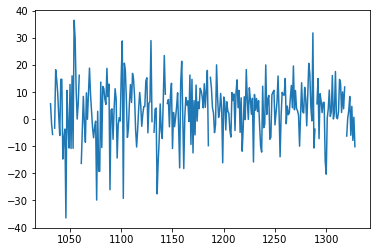

In [44]:
merged_df['odds_diff'] = merged_df['odd_home_prob'] - merged_df['home_win_probability']
merged_df[merged_df['league.season'] == 2022]['odds_diff'].plot()

## Betting Logic

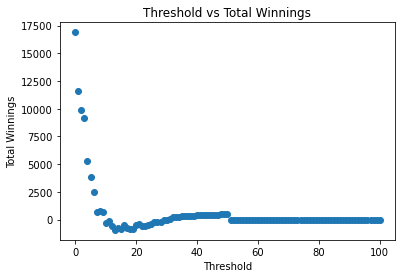

In [45]:
import matplotlib.pyplot as plt

def to_bet_1(row, thresh):
    ## the model really sucks between these probabilities so just don't even bet
    if row['home_win_probability'] > 45 and row['home_win_probability'] < 55:
        return 0
    # If my odds are greater than the book, bet on the match
    elif row['home_win_probability'] - row['odd_home_prob'] > thresh and row['home_win_probability'] > 55:
        return 1
    else:
        return 0
    
def to_bet_2(row, thresh):
    ## the model really sucks between these probabilities so just don't even bet
    if row['away_win_probability'] > 45 and row['away_win_probability'] < 55:
        return 0
    # If my odds are greater than the book, bet on the match
    elif row['away_win_probability'] - row['odd_away_prob'] > thresh and row['away_win_probability'] > 55:
        return 1
    else:
        return 0
    
def calculate_winnings_1(row):
    bet = 100  # Amount of money you bet on each game
    
    if row['to_bet_1'] == 1 and row['prediction_correct'] == "Yes" and row['home_team_won'] == 'Won':
        # The return is simply the bet times the decimal odds
        return bet * row['home_od']  - bet
    # elif row['to_bet_1'] == 1 and row['prediction_correct'] == "Yes" and row['home_team_won'] == 'Lost':
    #     # The return is simply the bet times the decimal odds
    #     return bet * row['away_od'] - bet
    elif row['to_bet_1'] == 1 and row['prediction_correct'] == "No":
        # If the bet was placed and the prediction was incorrect, the bet is lost
        return -bet
    else: 
        # If no bet was placed, there is neither a gain nor a loss
        return 0
    
def calculate_winnings_2(row):
    bet = 100  # Amount of money you bet on each game
    
    if row['to_bet_2'] == 1 and row['prediction_correct'] == "Yes" and row['home_team_won'] == 'Lost':
        # The return is simply the bet times the decimal odds
        return bet * row['home_od']  - bet
    elif row['to_bet_2'] == 1 and row['prediction_correct'] == "No":
        # If the bet was placed and the prediction was incorrect, the bet is lost
        return -bet
    else: 
        # If no bet was placed, there is neither a gain nor a loss
        return 0
    
# thresholds = []
# winnings = []

# # Loop over possible threshold values
# for thresh in range(0, 101):
#     merged_df['to_bet_1'] = merged_df.apply(lambda row: to_bet_1(row, thresh), axis=1)
#     merged_df['winnings_1'] = merged_df.apply(calculate_winnings_1, axis=1)
#     merged_df['to_bet_2'] = merged_df.apply(lambda row: to_bet_2(row, thresh), axis=1)
#     merged_df['winnings_2'] = merged_df.apply(calculate_winnings_2, axis=1)
#     total_winnings = merged_df['winnings_1'].sum() + merged_df['winnings_2'].sum()

#     # Append current threshold and total winnings to lists
#     thresholds.append(thresh)
#     winnings.append(total_winnings)

# # Create scatterplot
# plt.scatter(thresholds, winnings)
# plt.xlabel('Threshold')
# plt.ylabel('Total Winnings')
# plt.title('Threshold vs Total Winnings')
# plt.show()

In [46]:
data = merged_df
data

date  week teams.home.name  scores.home    teams.away.name  \
0     2016-09-14     3   Fuchse Berlin         36.0             Minden   
1     2016-09-14     3           Lemgo         28.0           Erlangen   
2     2016-09-14     4            Kiel         30.0          Goppingen   
3     2016-09-14     3         Leipzig         23.0  Hannover-Burgdorf   
4     2016-09-14     3    MT Melsungen         26.0       Rhein-Neckar   
...          ...   ...             ...          ...                ...   
1324  2023-06-11    34  Hamm-Westfalen         28.0            Leipzig   
1325  2023-06-11    34     HSG Wetzlar         30.0       SC Magdeburg   
1326  2023-06-11    34           Lemgo         35.0      Fuchse Berlin   
1327  2023-06-11    34          Minden         38.0        Gummersbach   
1328  2023-06-11    34       Stuttgart         31.0  Hannover-Burgdorf   

      scores.away  league.season  difference  home_elo_rating  \
0            26.0           2016        10.0      1609.366879   
1            27.0           2016         1.0      1414.193128   
2            21.0           2016         9.0      1690.717631   
3            25.0           2016        -2.0      1497.814941   
4            30.0           2016        -4.0      1551.198620   
...           ...            ...         ...              ...   
1324         33.0           2022        -5.0      1289.908552   
1325         35.0           2022        -5.0      1382.593553   
1326         32.0           2022         3.0      1564.311325   
1327         38.0           2022         0.0      1317.695457   
1328         34.0           2022        -3.0      1412.169846   

      away_elo_rating  home_elo_before_match  away_elo_before_match  \
0         1454.525983            1599.057684            1464.835178   
1         1455.214172            1405.374545            1464.032755   
2         1541.396745            1680.753871            1551.360505   
3         1537.633144            1507.444964            1528.003121   
4         1734.306372            1558.551429            1726.953563   
...               ...                    ...                    ...   
1324      1498.906273            1297.227330            1491.587495   
1325      1788.559570            1385.373228            1785.779895   
1326      1679.713735            1550.552490            1693.472570   
1327      1490.321137            1314.857372            1493.159223   
1328      1539.747398            1420.324508            1531.592736   

      home_win_probability  away_win_probability home_team_won  \
0                72.249141             27.750859           Won   
1                46.171086             53.828914           Won   
2                71.688351             28.311649           Won   
3                51.646019             48.353981          Lost   
4                31.320158             68.679842          Lost   
...                    ...                   ...           ...   
1324             28.198831             71.801169          Lost   
1325             10.709927             89.290073          Lost   
1326             34.558404             65.441596           Won   
1327             30.107561             69.892439          Tied   
1328             38.786284             61.213716          Lost   

     prediction_correct probability_bin       home.name          away.name  \
0                   Yes        (70, 75]   Fuchse Berlin             Minden   
1                    No        (45, 50]           Lemgo           Erlangen   
2                   Yes        (70, 75]            Kiel          Goppingen   
3                    No        (50, 55]         Leipzig  Hannover-Burgdorf   
4                   Yes        (30, 35]    MT Melsungen       Rhein-Neckar   
...                 ...             ...             ...                ...   
1324                Yes        (25, 30]  Hamm-Westfalen            Leipzig   
1325                Yes        (10, 15]     HSG Wetzlar       SC Magdebu

101
101


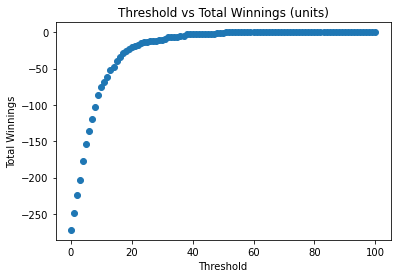

In [50]:
data['home_team_won'] = data['home_team_won'].map({'Won': 1, 'Lost': 0, 'Tied': 0})

thresholds2 = []
winnings2 = []

for thresh in range(0, 101):
    data['to_bet_1'] = data.apply(lambda row: to_bet_1(row, thresh), axis=1)
    data['winnings_1'] = data.apply(calculate_winnings_1, axis=1)
    data['to_bet_2'] = data.apply(lambda row: to_bet_2(row, thresh), axis=1)
    data['winnings_2'] = data.apply(calculate_winnings_2, axis=1)

    # Calculate potential winnings for each game if the home team won
    data['potential_winnings_1'] = data['to_bet_1'] * data['home_team_won'] * (data['home_od'] - 1)

    # Calculate potential winnings for each game if the away team won (home team did not win)
    data['potential_winnings_2'] = data['to_bet_2'] * (1 - data['home_team_won']) * (data['away_od'] - 1)

    # Calculate total potential winnings
    total_potential_winnings = data['potential_winnings_1'].sum() + data['potential_winnings_2'].sum()

    # Calculate total amount bet (assuming a bet of 1 unit per game)
    total_amount_bet = data['to_bet_1'].sum() + data['to_bet_2'].sum()

    # Calculate net profit
    net_profit = total_potential_winnings - total_amount_bet
    net_profit


    # Append current threshold and total winnings to lists
    thresholds2.append(thresh)
    winnings2.append(net_profit)

print(len(thresholds2))
print(len(winnings2))

# Create scatterplot
plt.scatter(thresholds2, winnings2)
plt.xlabel('Threshold')
plt.ylabel('Total Winnings')
plt.title('Threshold vs Total Winnings (units)')
plt.show()


### Next Steps

see if there's a way to profit on the fact that the odds change before a match as the book looks at sharp bettors
 
bet on all 3 to break even

add predicting a draw as 10% of matches are a draw

calculate predicting point spreads 

asian handicap

make ML model and optimize threshold of betting

percentage loss

if my win and loss are 10% apart don't bet


In [ ]:
# negative_mask = merged_df['winnings_1'] < 0
# negative_count = negative_mask.sum()
# positive_mask = merged_df['winnings_1'] > 0
# positive_count = positive_mask.sum()
# print(negative_count)
# print(positive_count)

0
0
